**NLP - COM3029 & COMM061 - Group 15**
- Abdelkader Bouregag (6707271)
- Sanchit Agarwal (6707777)
- Gopi Krishna Goli (6711997)
- Rosmin Ann Raju- (6693898)
-

### Introduction

This project aims at developing, and critically assessing, a task-oriented dialog chatbot. The chatbot in question is designed to help the user book a holiday trip package. In order to achieve this, the chatbot requires the following information from the user:
<ul>
<li>Source City</li>
<li>Destination City</li>
<li>No of people</li>
<li>Start Date</li>
<li>End Date</li>
<li>Budget</li>
</ul>

There are three main components to the chatbot:
<ol>
    <li>Intent Classifier</li>
    <li>Named Entity Recogniziner</li>
    <li>Dialog Flow Manager</li>
</ol>


### Model Serving options

When deploying a machine learning application, we first investigate the information and select the best model and preprocessing options. Then we train and evaluate the model till we achieve the desired outcomes. After coming up with a version of the model with the desired performance, it must be deployed, preferably over an HTTP endpoint, so that another application can use it. Here, we are using Flask as our web framework.

Flask is an open-source web platform popularly used for creating REST APIs, with roughly half of Python programmers using it in 2019. Flask is especially beneficial for delivering machine learning models because minimalism and adaptability are preferred over the "batteries included" all-in-one capabilities of other frameworks aimed at essential web development. The various components of the chatbot are deployed separately as a microservice, exposed using an HTTP endpoint. 

Microservices architecture allows an application to be deployed as a series of modular, self-contained web services, communicating with each other and to the main application using standard communication protocols such as RESTful APIs, SOAP APIs etc. We decided on using microservice architecture for our project since it allows the application to be highly scalable, fault-tolerant and cloud friendly.

We propose the following architecture:

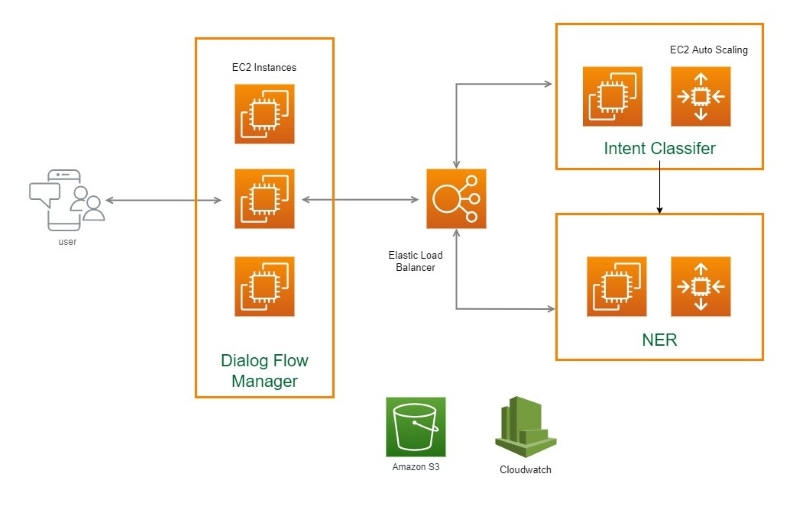

Using AWS as our cloud provider, each chatbot component will be deployed as a microservice using EC2 instances. The DialogFlow Manager will be the main point of contact for the user. The DialogFlow Manager, in turn, will call Intent Classifier and NER Labeller, both of which are deployed in their separate cluster. Load Balancer ensures the traffic is shared amongst all available resources. 

The persistent data, including models and logs, will be stored in S3. CloudWatch will provide maintenance and monitoring capabilities.

### Chatbot components

##a- Intent Classification (Kader)

Intenet component is reponsible for predicting the intent of a text. This component have two end-points: 
- /predict: Which takes a text as an input and perform the preprocessing as well as prediction of intent and returns an intent.
- /train: which perform a training of a new model,

### b- Name Entity recognition ( Rosmin )

Named Entity Recognition helps extract the entities from a text, i.e. divides the text into predefined categories like cities, individuals, organisations, etc.

SpaCy is an open and accessible source of Python library used for text classification, one of the most basic applications of NLP. It has a good NER accuracy of 85.85% 

To work with SpaCy, we need to transform the data into SpaCy format:

```
Array(input_text_1 ,entities: Array(start_index, end_index, entity_name), (start_index, end_index, ...]), 
      input_text_2 ,entities: Array(start_index, end_index, entity_name), (start_index, end_index, ...]), ....)
```

We would use Spacy's Spancategorizer and the SpaCy NER to measure the confidence score of the NER model as it can potentially overlap and predicts scores and labels for the asked spans. In contrast, the NER model takes single token-based tags.

### c- Dialogue Flow (Sanchit)

The dialogue flow component is responsible for managing the state of the chatbot and deciding on the next course of action based on the policy established according to the business requirements. This component also develops the response sentence based on the state of the chatbot and what more information it needs to reach the target state. 

For this project, we have implemented a rule-based dialogue state tracker which uses the predicted intent from the Intent Classifier component, alongside the previous state of the chatbot, to establish the next state of the chatbot.

The possible states the chatbot could be in are:
<ul>
    <li><h4>Greetings</h4><p>Initial state of the chatbot. This state is transitioned from a dummy state. This is due to the limitation of the pyTransitions library</p></li>
        <li><h4>Question</h4><p>In this stage, chatbot asks a question to the user, especially when it detects that the user doesnn't intent to book a trip package.</p></li>
        <li><h4>Inform</h4><p>In this stage, the chatbot queries the user to gather information it needs to successfully book the package</p></li>
        <li><h4>Affirm</h4><p>Here, chatbot is basically confirming with the user whether it should execute the query (In this case, booking a trip package based on the information provided by the user)</p></li>
        <li><h4>Update</h4><p>If the chatbot detects the user intents to update the information it has provided to the chatbot , the chatbot will transition to this state</p></li>
        <li><h4>End</h4><p>The chatbot transitions to this state when it has completed its objective.</p></li>
</ul>


           
This component provides the final endpoint to a functioning chatbot.


### Testing of Chatbot

Here we will be testing the different components of the chatbot individually for the accuracy and the average response time. The services which are being tested will be running on a local desktop computer, with only 1 instance running. 

In [8]:
#Intent Classifier#

from datetime import datetime
from statistics import mean
import requests
intent_url = "http://127.0.0.1:5001/predict"

texts = ["I'd like to book a trip to Atlantis from Caprica on Saturday, August 13, 2016 for 8 adults. I have a tight budget of 1700.",
          "What about a trip from Gotham City to Neverland for the same budget?",
          "Well how much money are they each?",
          "6500 is my maximum. if the 13 day package is still within my dates i will look at it",
          "Will you like me to proceed with the booking?",
          "I have the perfect package in Osaka for you at 789.67USD, but only if you can depart from Busan, South Korea. Are you able to swing that?"]

durations = []

for text in texts:
    start_time = datetime.now()
    response = requests.get(intent_url, params={"text": text})
    intent = str(response.text)
    print(intent)
    durations.append((datetime.now()- start_time).total_seconds())

print('Average Duration: {}'.format(mean(durations)))

book
inform
request_compare
switch_frame
book
inform
Average Duration: 7.0307805


Merits:
1. I observed that after giving variety of texts as input, the intent model or algorithm is predicting quite accurately for most of the inputs.
2. Like for the intents 'book', 'switch_frame', 'request_compare', 'inform' the model is predicting correct outputs.

Demerits:
1. The model's accuracy is pretty good with 71% but remaining 29% is what it's failing to predict other intents properly.
2. Like for the intent 'offer' the model here predicted as 'inform', Similarly, for the intent 'suggest', the model still predicted as 'inform'

Conclusion-As the majority of the intents are from 'inform', wherever it's failing to predict right intent, it is taking the major intent i.e. 'inform'.

In [10]:
#NER Classifier#

from datetime import datetime
from statistics import mean
import requests
import json

ner_url = "http://127.0.0.1:5002/predict"

texts = ["hi im from Coruscant looking to go to atlantis",
          "You will arrive in Queenstown on September 12 and stay at the Emerald Mountain Hotel. You will return to Fort Lauderdale on September 20th.",
          "Hey there! I'm unable to come up with anything for those locations, how about a trip from Cleveland to San Juan?",
          "Hotel Fernando Ribero",
         "Kakariko Village eh? I'm having trouble finding that location."]

durations = []

for text in texts:
    start_time = datetime.now()
    response = requests.get(ner_url, params={"text": text})
    ner = json.loads(response.content.decode('utf-8'))
    print(ner)
    durations.append((datetime.now()- start_time).total_seconds())


print('Average Duration: {}'.format(mean(durations)))

{}
{'dst_city': 'Fort', 'str_date': 'September'}
{'dst_city': 'San'}
{}
{}
Average Duration: 3.4231694


It can be seen that the model accuracy is not good as a result it is not predicting all the entities in that particular text. 
By changing the learning rate and using better optimizer, we can improve the accuracy but it's still not giving the good result. 

### Performance of Chatbot

In [18]:
#Intent Classifier#

from datetime import datetime
from threading import Thread
import requests

intent_url = "http://127.0.0.1:5001/predict"
ner_url = "http://127.0.0.1:5002/predict"


def task():
    text = "I'd like to book a trip to Atlantis from Caprica on Saturday, August 13, 2016 for 8 adults. I have a tight budget of 1700"        
    response1 = requests.get(intent_url, params={"text": text})
    response2 = requests.get(ner_url, params={"text": text})


durations = []

thread_counts = [10, 50, 100]

for thread_count in thread_counts:
    thread_pool = []
    start_time = datetime.now()
    
    for _ in range(thread_count):
        new_thread = Thread(target=task)
        new_thread.start()
        thread_pool.append(new_thread)
    
    [x.join() for x in thread_pool]
    
    durations.append((datetime.now()- start_time).total_seconds())
    print('Time taken for {0} parallel executions {1}'.format(thread_count, (datetime.now()- start_time).total_seconds()))

print('Time taken for 10 parallel executions {}'.format(durations[0]))
print('Time taken for 50 parallel executions {}'.format(durations[1]))
print('Time taken for 100 parallel executions {}'.format(durations[2]))

Time taken for 10 parallel executions 37.485482
Time taken for 50 parallel executions 1011.056213
Time taken for 100 parallel executions 1916.059452
Time taken for 10 parallel executions 37.485454
Time taken for 50 parallel executions 1011.056204
Time taken for 100 parallel executions 1916.059444


#**5- Monitoring capability (log file)** (Kader)

Build some basic monitoring capability to capture user inputs and the model predictions,
and store those in a log file. There is no need to build functionality that will detect any
concept drift

#**6- CI/CD Pipeline:** (Vankat)

Build a basic CI/CD pipeline that will build and deploy the chatbot components when data or
code changes. There is no need to trigger this automatically, so a manually executed script
will suffice.

#**7-Link to 10 min screen recording demo** (Sanchit and Kader)